In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pickle
import time
from datetime import datetime, timedelta
import pytz
import logging
from sklearn.ensemble import RandomForestRegressor

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Define time zones
eastern = pytz.timezone('US/Eastern')
utc = pytz.utc

# Define market open and close times
market_open = datetime.now(eastern).replace(hour=9, minute=30, second=0, microsecond=0)
market_close = datetime.now(eastern).replace(hour=16, minute=0, second=0, microsecond=0)

# Symbol to trade
symbol = 'AAPL'

def get_data(symbol, period="1d", interval="1m"):
    max_retries = 3
    for attempt in range(max_retries):
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(period=period, interval=interval)
            if not data.empty:
                return data
            else:
                logging.warning(f"Empty data returned for {symbol}. Retrying...")
        except Exception as e:
            logging.error(f"Error fetching data for {symbol}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    return None

def create_features(data, lookback=5, for_prediction=False):
    if len(data) < lookback:
        logging.warning("Not enough data to create features. Waiting for more data...")
        return np.array([])

    close = data['Close'].values[-lookback:]
    volume = data['Volume'].values[-lookback:]
    pct_change = data['Close'].pct_change().values[-lookback+1:]
    ma_diff = (data['Close'] - data['Close'].rolling(window=5).mean()).values[-lookback:]

    logging.debug(f"Close shape: {close.shape}")
    logging.debug(f"Volume shape: {volume.shape}")
    logging.debug(f"Pct change shape: {pct_change.shape}")
    logging.debug(f"MA diff shape: {ma_diff.shape}")

    # Ensure all arrays have the same length
    min_length = min(len(close), len(volume), len(pct_change), len(ma_diff))
    features = np.column_stack([
        close[-min_length:],
        volume[-min_length:],
        pct_change[-min_length:],
        ma_diff[-min_length:]
    ])

    logging.debug(f"Final features shape: {features.shape}")

    if for_prediction:
        return features[-1].reshape(1, -1)  # Return only the last row for prediction
    return features

def train_models(data):
    X = create_features(data[:-1])
    if X.size == 0:
        logging.warning("Not enough data to train models. Waiting for more data...")
        return None, None, None

    logging.debug(f"X shape: {X.shape}")

    y_close = data['Close'].values[-X.shape[0]:]
    y_high = data['High'].values[-X.shape[0]:]
    y_low = data['Low'].values[-X.shape[0]:]

    logging.debug(f"y_close shape: {y_close.shape}")
    logging.debug(f"y_high shape: {y_high.shape}")
    logging.debug(f"y_low shape: {y_low.shape}")

    model_close = RandomForestRegressor(n_estimators=100, random_state=42)
    model_high = RandomForestRegressor(n_estimators=100, random_state=42)
    model_low = RandomForestRegressor(n_estimators=100, random_state=42)

    model_close.fit(X, y_close)
    model_high.fit(X, y_high)
    model_low.fit(X, y_low)

    return model_close, model_high, model_low

def save_models(model_close, model_high, model_low):
    with open('model_close.pkl', 'wb') as f:
        pickle.dump(model_close, f)
    with open('model_high.pkl', 'wb') as f:
        pickle.dump(model_high, f)
    with open('model_low.pkl', 'wb') as f:
        pickle.dump(model_low, f)
    logging.info("Models saved.")

# Wait for market open
current_time = datetime.now(eastern)
if current_time < market_open:
    wait_time = (market_open - current_time).total_seconds()
    logging.info(f"Waiting {wait_time:.5f} seconds for market open...")
    time.sleep(wait_time)

logging.info("Starting data collection and model training...")

while datetime.now(eastern) < market_close:
    try:
        # Fetch new 1-minute data
        data = get_data(symbol)
        
        if data is None or len(data) < 6:
            logging.warning("Not enough data to proceed. Waiting for next minute...")
            time.sleep(60)
            continue
        
        # Train models
        model_close, model_high, model_low = train_models(data)
        
        if model_close is None or model_high is None or model_low is None:
            logging.warning("Models could not be trained. Waiting for next minute...")
            time.sleep(60)
            continue
        
        # Save models
        save_models(model_close, model_high, model_low)
        
        # Make predictions for the next 5-minute close
        features = create_features(data, for_prediction=True)
        if features.size == 0:
            logging.warning("Not enough data to create features. Waiting for next minute...")
            time.sleep(60)
            continue

        logging.debug(f"Prediction features shape: {features.shape}")

        prediction_close = model_close.predict(features)
        prediction_high = model_high.predict(features)
        prediction_low = model_low.predict(features)
        
        # Log predictions
        logging.info(f"Predictions - Close: {prediction_close[0]:.2f}, High: {prediction_high[0]:.2f}, Low: {prediction_low[0]:.2f}")
        
        # Wait until the next minute
        time.sleep(60)
        
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        logging.exception("Exception details:")
        time.sleep(60)

logging.info("Market closed. Ending data collection and model training.")

2024-09-13 16:02:21,274 - INFO - Starting data collection and model training...
2024-09-13 16:02:21,276 - DEBUG - Entering history()
2024-09-13 16:02:21,283 - DEBUG - ('CREATE TABLE IF NOT EXISTS "_kv" ("key" VARCHAR(255) NOT NULL PRIMARY KEY, "value" VARCHAR(255)) WITHOUT ROWID', [])
2024-09-13 16:02:21,283 - DEBUG - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['AAPL', 1, 0])
2024-09-13 16:02:21,284 - DEBUG -  Entering history()
2024-09-13 16:02:21,285 - DEBUG - AAPL: Yahoo GET parameters: {'range': '1d', 'interval': '1m', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
2024-09-13 16:02:21,285 - DEBUG -   Entering get()
2024-09-13 16:02:21,285 - DEBUG - url=https://query2.finance.yahoo.com/v8/finance/chart/AAPL
2024-09-13 16:02:21,286 - DEBUG - params={'range': '1d', 'interval': '1m', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
2024-09-13 16:02:21,286 - DEBUG -    Entering _get_cookie_and_crumb()
2024-0

// TradingView Pine Script for AAPL Intraday Strategy

//@version=5
strategy("AAPL Intraday Strategy", overlay=true)

// Input for predicted prices (these would be updated externally in a real scenario)
predicted_close = input.float(title="Predicted Close", defval=0.0)
predicted_high = input.float(title="Predicted High", defval=0.0)
predicted_low = input.float(title="Predicted Low", defval=0.0)

// Get current price
current_price = close

// Variables to track position
var in_position = false
var entry_price = 0.0

// Strategy logic
if not in_position and predicted_high > current_price and predicted_high > predicted_close
    strategy.entry("Long", strategy.long)
    in_position := true
    entry_price := current_price

// Close position when predicted high is reached
if in_position and high >= predicted_high
    strategy.close("Long")
    in_position := false
    entry_price := 0.0

// Plot predictions
plot(predicted_close, color=color.blue, title="Predicted Close")
plot(predicted_high, color=color.green, title="Predicted High")
plot(predicted_low, color=color.red, title="Predicted Low")

// Add labels for visibility
if barstate.islast
    label.new(bar_index, predicted_close, "Predicted Close", color=color.blue, textcolor=color.white, style=label.style_label_down)
    label.new(bar_index, predicted_high, "Predicted High", color=color.green, textcolor=color.white, style=label.style_label_up)
    label.new(bar_index, predicted_low, "Predicted Low", color=color.red, textcolor=color.white, style=label.style_label_down)




In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import logging
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to fetch historical data
def get_historical_data(symbol, date):
    try:
        ticker = yf.Ticker(symbol)
        start_date = date.replace(hour=9, minute=30)
        end_date = date.replace(hour=16, minute=0)
        data = ticker.history(start=start_date, end=end_date, interval="5m")
        return data
    except Exception as e:
        logging.error(f"Error fetching data: {e}")
        return None

# Extract predictions from the log
predictions = [
    (datetime(2024, 9, 12, 12, 0), 222.06),
    (datetime(2024, 9, 12, 12, 5), 221.95),
    (datetime(2024, 9, 12, 12, 10), 222.07),
    (datetime(2024, 9, 12, 12, 15), 221.96),
    (datetime(2024, 9, 12, 12, 20), 221.99),
    (datetime(2024, 9, 12, 12, 25), 221.73),
    (datetime(2024, 9, 12, 12, 30), 221.93),
    (datetime(2024, 9, 12, 12, 35), 221.98),
    (datetime(2024, 9, 12, 12, 40), 221.95),
    (datetime(2024, 9, 12, 12, 45), 221.85),
    (datetime(2024, 9, 12, 12, 50), 221.87),
    (datetime(2024, 9, 12, 12, 55), 221.95),
    (datetime(2024, 9, 12, 13, 0), 222.16),
    (datetime(2024, 9, 12, 13, 5), 222.55),
    (datetime(2024, 9, 12, 13, 10), 222.63),
    (datetime(2024, 9, 12, 13, 15), 222.81),
    (datetime(2024, 9, 12, 13, 20), 222.78),
    (datetime(2024, 9, 12, 13, 25), 222.63),
    (datetime(2024, 9, 12, 13, 30), 222.82),
    (datetime(2024, 9, 12, 13, 34), 222.50),
    (datetime(2024, 9, 12, 13, 39), 222.81),
    (datetime(2024, 9, 12, 13, 45), 222.92),
    (datetime(2024, 9, 12, 13, 50), 222.86),
    (datetime(2024, 9, 12, 13, 55), 222.95),
    (datetime(2024, 9, 12, 14, 0), 223.07),
    (datetime(2024, 9, 12, 14, 5), 223.05),
    (datetime(2024, 9, 12, 14, 10), 223.07),
    (datetime(2024, 9, 12, 14, 15), 223.01),
    (datetime(2024, 9, 12, 14, 20), 222.81),
    (datetime(2024, 9, 12, 14, 25), 222.87),
    (datetime(2024, 9, 12, 14, 30), 223.06),
    (datetime(2024, 9, 12, 14, 35), 223.13),
    (datetime(2024, 9, 12, 14, 40), 223.13),
    (datetime(2024, 9, 12, 14, 45), 223.46),
    (datetime(2024, 9, 12, 14, 50), 223.42),
    (datetime(2024, 9, 12, 14, 55), 223.42),
    (datetime(2024, 9, 12, 15, 0), 222.94),
    (datetime(2024, 9, 12, 15, 5), 223.00),
    (datetime(2024, 9, 12, 15, 10), 223.10),
    (datetime(2024, 9, 12, 15, 15), 223.42),
    (datetime(2024, 9, 12, 15, 20), 223.12),
    (datetime(2024, 9, 12, 15, 25), 223.13),
    (datetime(2024, 9, 12, 15, 30), 222.99),
    (datetime(2024, 9, 12, 15, 35), 222.89),
    (datetime(2024, 9, 12, 15, 40), 223.04),
    (datetime(2024, 9, 12, 15, 45), 223.04),
    (datetime(2024, 9, 12, 15, 50), 223.25),
    (datetime(2024, 9, 12, 15, 55), 222.62),
    (datetime(2024, 9, 12, 16, 0), 222.61),
]

# Set up the date for yesterday
symbol = "GME"
eastern = pytz.timezone('US/Eastern')
yesterday = datetime(2024, 9, 12).replace(tzinfo=eastern)

logging.info("Fetching historical data...")

# Fetch yesterday's data
actual_data = get_historical_data(symbol, yesterday)

if actual_data is None or len(actual_data) < 6:
    logging.error("Not enough data to proceed. Exiting.")
    exit()

# Prepare data for comparison
pred_df = pd.DataFrame(predictions, columns=['Timestamp', 'Predicted'])
pred_df['Timestamp'] = pred_df['Timestamp'].dt.tz_localize(eastern)
pred_df.set_index('Timestamp', inplace=True)

# Merge predicted and actual data
combined_df = pd.merge(pred_df, actual_data['Close'], left_index=True, right_index=True, how='inner')
combined_df.columns = ['Predicted', 'Actual']

# Calculate metrics
mse = mean_squared_error(combined_df['Actual'], combined_df['Predicted'])
mae = mean_absolute_error(combined_df['Actual'], combined_df['Predicted'])

logging.info(f"Mean Squared Error: {mse:.4f}")
logging.info(f"Mean Absolute Error: {mae:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Predicted'], label='Predicted Price', marker='o')
plt.plot(combined_df.index, combined_df['Actual'], label='Actual Price', marker='x')
plt.title(f'{symbol} Stock Price: Predicted vs Actual (2024-09-12)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prediction_vs_actual_2024-09-12.png')
plt.close()

# Print summary statistics
logging.info("\nSummary Statistics:")
logging.info(f"Total predictions: {len(combined_df)}")
logging.info(f"Average predicted price: ${combined_df['Predicted'].mean():.2f}")
logging.info(f"Average actual price: ${combined_df['Actual'].mean():.2f}")
logging.info(f"Minimum predicted price: ${combined_df['Predicted'].min():.2f}")
logging.info(f"Maximum predicted price: ${combined_df['Predicted'].max():.2f}")
logging.info(f"Minimum actual price: ${combined_df['Actual'].min():.2f}")
logging.info(f"Maximum actual price: ${combined_df['Actual'].max():.2f}")

2024-09-13 05:58:14,283 - INFO - Fetching historical data...
2024-09-13 05:58:14,753 - INFO - Mean Squared Error: 40957.0596
2024-09-13 05:58:14,753 - INFO - Mean Absolute Error: 202.3781
2024-09-13 05:58:14,880 - INFO - 
Summary Statistics:
2024-09-13 05:58:14,880 - INFO - Total predictions: 46
2024-09-13 05:58:14,880 - INFO - Average predicted price: $222.71
2024-09-13 05:58:14,882 - INFO - Average actual price: $20.33
2024-09-13 05:58:14,882 - INFO - Minimum predicted price: $221.73
2024-09-13 05:58:14,882 - INFO - Maximum predicted price: $223.46
2024-09-13 05:58:14,883 - INFO - Minimum actual price: $20.12
2024-09-13 05:58:14,883 - INFO - Maximum actual price: $20.64


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import logging
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to fetch historical data
def get_historical_data(symbol, date):
    try:
        ticker = yf.Ticker(symbol)
        start_date = date.replace(hour=9, minute=30)
        end_date = date.replace(hour=16, minute=0)
        data = ticker.history(start=start_date, end=end_date, interval="5m")
        return data
    except Exception as e:
        logging.error(f"Error fetching data: {e}")
        return None

# Extract predictions from the log
predictions = [

    (datetime(2024, 9, 12, 12, 0), 222.06),
    (datetime(2024, 9, 12, 12, 5), 221.95),
    (datetime(2024, 9, 12, 12, 10), 222.07),
    (datetime(2024, 9, 12, 12, 15), 221.96),
    (datetime(2024, 9, 12, 12, 20), 221.99),
    (datetime(2024, 9, 12, 12, 25), 221.73),
    (datetime(2024, 9, 12, 12, 30), 221.93),
    (datetime(2024, 9, 12, 12, 35), 221.98),
    (datetime(2024, 9, 12, 12, 40), 221.95),
    (datetime(2024, 9, 12, 12, 45), 221.85),
    (datetime(2024, 9, 12, 12, 50), 221.87),
    (datetime(2024, 9, 12, 12, 55), 221.95),
    (datetime(2024, 9, 12, 13, 0), 222.16),
    (datetime(2024, 9, 12, 13, 5), 222.55),
    (datetime(2024, 9, 12, 13, 10), 222.63),
    (datetime(2024, 9, 12, 13, 15), 222.81),
    (datetime(2024, 9, 12, 13, 20), 222.78),
    (datetime(2024, 9, 12, 13, 25), 222.63),
    (datetime(2024, 9, 12, 13, 30), 222.82),
    (datetime(2024, 9, 12, 13, 34), 222.50),
    (datetime(2024, 9, 12, 13, 39), 222.81),
    (datetime(2024, 9, 12, 13, 45), 222.92),
    (datetime(2024, 9, 12, 13, 50), 222.86),
    (datetime(2024, 9, 12, 13, 55), 222.95),
    (datetime(2024, 9, 12, 14, 0), 223.07),
    (datetime(2024, 9, 12, 14, 5), 223.05),
    (datetime(2024, 9, 12, 14, 10), 223.07),
    (datetime(2024, 9, 12, 14, 15), 223.01),
    (datetime(2024, 9, 12, 14, 20), 222.81),
    (datetime(2024, 9, 12, 14, 25), 222.87),
    (datetime(2024, 9, 12, 14, 30), 223.06),
    (datetime(2024, 9, 12, 14, 35), 223.13),
    (datetime(2024, 9, 12, 14, 40), 223.13),
    (datetime(2024, 9, 12, 14, 45), 223.46),
    (datetime(2024, 9, 12, 14, 50), 223.42),
    (datetime(2024, 9, 12, 14, 55), 223.42),
    (datetime(2024, 9, 12, 15, 0), 222.94),
    (datetime(2024, 9, 12, 15, 5), 223.00),
    (datetime(2024, 9, 12, 15, 10), 223.10),
    (datetime(2024, 9, 12, 15, 15), 223.42),
    (datetime(2024, 9, 12, 15, 20), 223.12),
    (datetime(2024, 9, 12, 15, 25), 223.13),
    (datetime(2024, 9, 12, 15, 30), 222.99),
    (datetime(2024, 9, 12, 15, 35), 222.89),
    (datetime(2024, 9, 12, 15, 40), 223.04),
    (datetime(2024, 9, 12, 15, 45), 223.04),
    (datetime(2024, 9, 12, 15, 50), 223.25),
    (datetime(2024, 9, 12, 15, 55), 222.62),
    (datetime(2024, 9, 12, 16, 0), 222.61),
    ]

# Set up the date for yesterday
symbol = "AAPL"
eastern = pytz.timezone('US/Eastern')
yesterday = datetime(2024, 9, 12).replace(tzinfo=eastern)

logging.info("Fetching historical data...")

# Fetch yesterday's data
actual_data = get_historical_data(symbol, yesterday)

if actual_data is None or len(actual_data) < 6:
    logging.error("Not enough actual data to proceed. Exiting.")
    exit()

# Prepare data for comparison
pred_df = pd.DataFrame(predictions, columns=['Timestamp', 'Predicted'])
pred_df['Timestamp'] = pred_df['Timestamp'].dt.tz_localize(eastern)
pred_df.set_index('Timestamp', inplace=True)

# Merge predicted and actual data
combined_df = pd.merge(pred_df, actual_data['Close'], left_index=True, right_index=True, how='inner')
combined_df.columns = ['Predicted', 'Actual']

# Log data information
logging.info(f"Number of predictions: {len(pred_df)}")
logging.info(f"Number of actual data points: {len(actual_data)}")
logging.info(f"Number of matched data points: {len(combined_df)}")

if len(combined_df) == 0:
    logging.error("No matching data points between predictions and actual data. Cannot proceed.")
    exit()

# Calculate metrics
mse = mean_squared_error(combined_df['Actual'], combined_df['Predicted'])
mae = mean_absolute_error(combined_df['Actual'], combined_df['Predicted'])

logging.info(f"Mean Squared Error: {mse:.4f}")
logging.info(f"Mean Absolute Error: {mae:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Predicted'], label='Predicted Price', marker='o')
plt.plot(combined_df.index, combined_df['Actual'], label='Actual Price', marker='x')
plt.title(f'{symbol} Stock Price: Predicted vs Actual (2024-09-12)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('prediction_vs_actual_2024-09-12.png', dpi=300)
plt.close()

# Print summary statistics
logging.info("\nSummary Statistics:")
logging.info(f"Total matched predictions: {len(combined_df)}")
logging.info(f"Average predicted price: ${combined_df['Predicted'].mean():.2f}")
logging.info(f"Average actual price: ${combined_df['Actual'].mean():.2f}")
logging.info(f"Minimum predicted price: ${combined_df['Predicted'].min():.2f}")
logging.info(f"Maximum predicted price: ${combined_df['Predicted'].max():.2f}")
logging.info(f"Minimum actual price: ${combined_df['Actual'].min():.2f}")
logging.info(f"Maximum actual price: ${combined_df['Actual'].max():.2f}")

2024-09-13 05:58:18,198 - INFO - Fetching historical data...
2024-09-13 05:58:18,294 - INFO - Number of predictions: 49
2024-09-13 05:58:18,295 - INFO - Number of actual data points: 67
2024-09-13 05:58:18,295 - INFO - Number of matched data points: 46
2024-09-13 05:58:18,296 - INFO - Mean Squared Error: 0.0601
2024-09-13 05:58:18,296 - INFO - Mean Absolute Error: 0.1962
2024-09-13 05:58:18,609 - INFO - 
Summary Statistics:
2024-09-13 05:58:18,609 - INFO - Total matched predictions: 46
2024-09-13 05:58:18,610 - INFO - Average predicted price: $222.71
2024-09-13 05:58:18,610 - INFO - Average actual price: $222.75
2024-09-13 05:58:18,611 - INFO - Minimum predicted price: $221.73
2024-09-13 05:58:18,611 - INFO - Maximum predicted price: $223.46
2024-09-13 05:58:18,612 - INFO - Minimum actual price: $221.74
2024-09-13 05:58:18,612 - INFO - Maximum actual price: $223.51


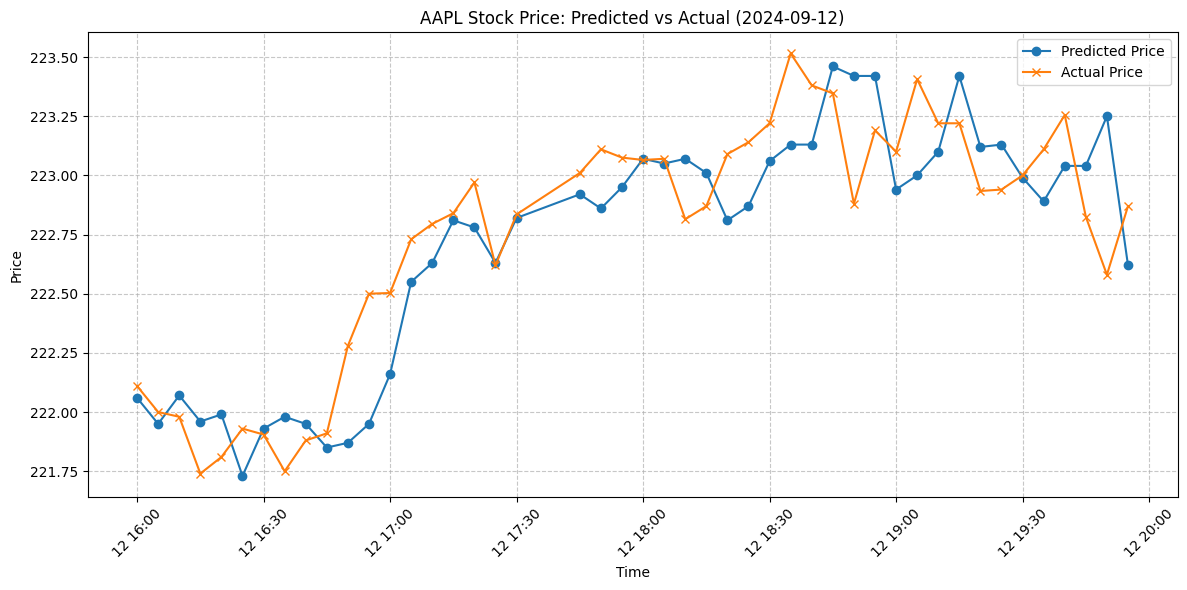

In [3]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Predicted'], label='Predicted Price', marker='o')
plt.plot(combined_df.index, combined_df['Actual'], label='Actual Price', marker='x')
plt.title(f'{symbol} Stock Price: Predicted vs Actual (2024-09-12)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot in the notebook
plt.show()

# Save the plot as an image file
plt.savefig('prediction_vs_actual_2024-09-12.png', dpi=300)
plt.close()


In [10]:
# Create a DataFrame for actual and predicted prices
df_comparison = pd.DataFrame({
    'Predicted': combined_df['Predicted'],
    'Actual': combined_df['Actual']
})

# Display the first few rows of the DataFrame
print(df_comparison.head(46))

# Calculate and display some basic statistics
print("\nBasic Statistics:")
print(df_comparison.describe())

# Calculate the difference between predicted and actual prices
df_comparison['Difference'] = df_comparison['Predicted'] - df_comparison['Actual']

# Display summary of the differences
print("\nSummary of Differences (Predicted - Actual):")
print(df_comparison['Difference'].describe())

# Calculate and display the correlation between actual and predicted prices
correlation = df_comparison['Actual'].corr(df_comparison['Predicted'])
# print(f"\nCorrelation between Actual and Predicted prices: {correlation:.4f}")


                           Predicted      Actual
2024-09-12 16:00:00+00:00     222.06  222.110001
2024-09-12 16:05:00+00:00     221.95  222.000000
2024-09-12 16:10:00+00:00     222.07  221.979996
2024-09-12 16:15:00+00:00     221.96  221.740005
2024-09-12 16:20:00+00:00     221.99  221.809998
2024-09-12 16:25:00+00:00     221.73  221.929993
2024-09-12 16:30:00+00:00     221.93  221.904999
2024-09-12 16:35:00+00:00     221.98  221.750000
2024-09-12 16:40:00+00:00     221.95  221.880005
2024-09-12 16:45:00+00:00     221.85  221.910004
2024-09-12 16:50:00+00:00     221.87  222.279999
2024-09-12 16:55:00+00:00     221.95  222.500000
2024-09-12 17:00:00+00:00     222.16  222.502899
2024-09-12 17:05:00+00:00     222.55  222.729996
2024-09-12 17:10:00+00:00     222.63  222.794998
2024-09-12 17:15:00+00:00     222.81  222.840103
2024-09-12 17:20:00+00:00     222.78  222.970001
2024-09-12 17:25:00+00:00     222.63  222.619995
2024-09-12 17:30:00+00:00     222.82  222.835007
2024-09-12 17:45:00+